In [ ]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import sklearn 
sklearn.__version__

'0.22.1'

# Advanced Machine Learning Models in Finance

All the recipes use `scikit-learn` version `0.21` (unless specified otherwise). From `0.22`, the default settings of selected estimators are changed. For example, in the case of the `RandomForestClassifier`, the default setting of `n_estimators` was changed from 10 to 100. This will cause discrepancies with the results presented in the book.

## Investigating advanced classifiers

### Getting Ready

Prepare the Pipeline:

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
#from chapter_9_utils import performance_evaluation_report

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [21]:
 
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = metrics.precision_score(y_test, y_pred),
    recall = metrics.recall_score(y_test, y_pred),

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision_vec, recall_vec, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall_vec, precision_vec)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall_vec, precision_vec, 
                       label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].plot(recall, precision, 'ro',
                       markersize=8, label='Decision Point')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')          
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [76]:
df = pd.read_csv('https://github.com/PacktPublishing/Python-for-Finance-Cookbook/blob/master/Datasets/credit_card_default.csv?raw=true', 
                 index_col=0, na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

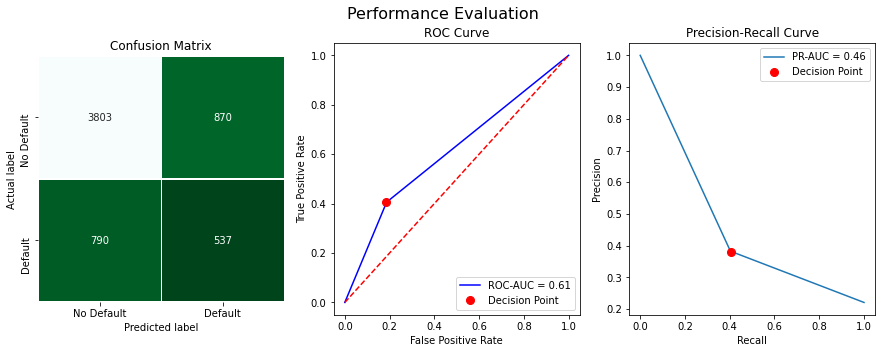

In [64]:


num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_list = [list(X_train[column].dropna().unique()) for column in cat_features]

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown='error', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', DecisionTreeClassifier(random_state=42))])

tree_pipeline.fit(X_train, y_train)

LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True, 
                                          show_pr_curve=True)

In [65]:
df

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,Unknown,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,NaN,High school,Married,39.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,Male,High school,Single,43.0,Payed duly,Payed duly,Payed duly,Payed duly,Unknown,Unknown,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,Male,University,Single,37.0,Payment delayed 4 months,Payment delayed 3 months,Payment delayed 2 months,Payed duly,Unknown,Unknown,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,Male,High school,Married,41.0,Payment delayed 1 month,Payed duly,Unknown,Unknown,Unknown,Payed duly,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [69]:
df.corr()['default_payment_next_month'].sort_values(ascending=False)

default_payment_next_month    1.000000
age                           0.014491
bill_statement_apr           -0.005372
bill_statement_may           -0.006760
bill_statement_jun           -0.010156
bill_statement_jul           -0.014076
bill_statement_aug           -0.014193
bill_statement_sep           -0.019644
previous_payment_apr         -0.053183
previous_payment_may         -0.055124
previous_payment_jul         -0.056250
previous_payment_jun         -0.056827
previous_payment_aug         -0.058579
previous_payment_sep         -0.072929
limit_bal                    -0.153520
Name: default_payment_next_month, dtype: float64

In [ ]:
tree_perf

{'accuracy': 0.7233333333333334,
 'cohens_kappa': 0.21388003714653614,
 'f1_score': 0.3928310168251646,
 'pr_auc': 0.4589251149708047,
 'precision': 0.3816631130063966,
 'recall': 0.4046721929163527,
 'roc_auc': 0.6095279347712678,
 'specificity': 0.8138240958698909}

In [ ]:
# investigate the depth of the tree
tree_classifier = tree_pipeline.named_steps['classifier']
tree_classifier.tree_.max_depth

37

### How to do it...

1. Import the libraries:

In [17]:
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

2. Create a Random Forest Pipeline:

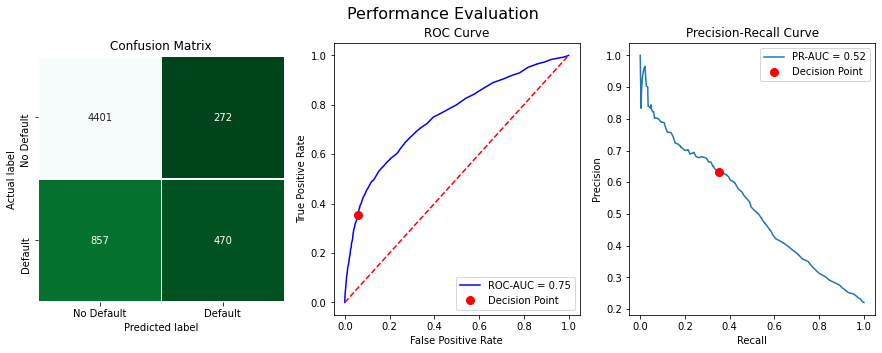

In [23]:
rf = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf)
                             ])

rf_pipeline.fit(X_train, y_train)
rf_perf = performance_evaluation_report(rf_pipeline, X_test, 
                                        y_test, labels=LABELS, 
                                        show_plot=True,
                                        show_pr_curve=True)

# plt.savefig('images/ch9_im1.png', dpi=300)
plt.show()

3. Create a Gradient Boosting Trees Pipeline:

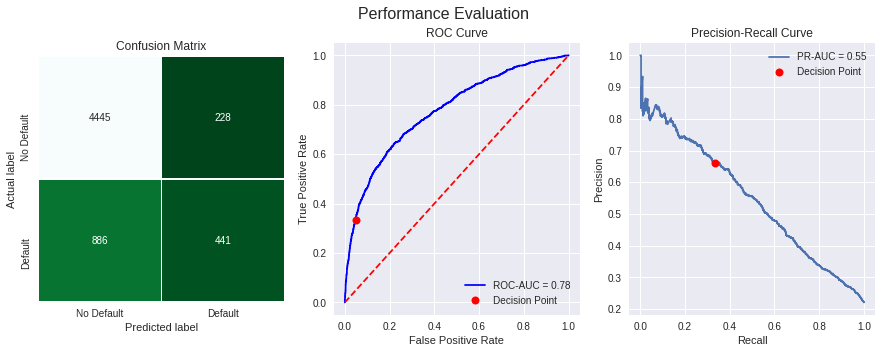

In [ ]:
gbt =  GradientBoostingClassifier(random_state=42)
gbt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', gbt)
                              ])

gbt_pipeline.fit(X_train, y_train)
gbt_perf = performance_evaluation_report(gbt_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True,
                                         show_pr_curve=True)

# plt.savefig('images/ch9_im2.png', dpi=300)
plt.show()

4. Create a xgBoost Pipeline:

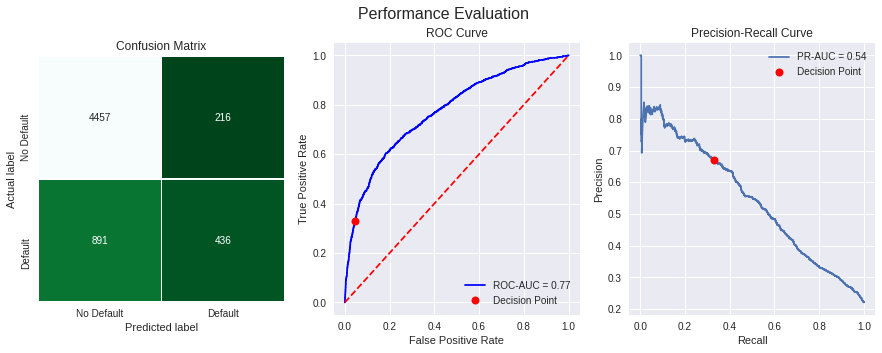

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb)
                              ])

xgb_pipeline.fit(X_train, y_train)
xgb_perf = performance_evaluation_report(xgb_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True,
                                         show_pr_curve=True)

# plt.savefig('images/ch9_im3.png', dpi=300)
plt.show()

5. Create a LightGBM classifier Pipeline:

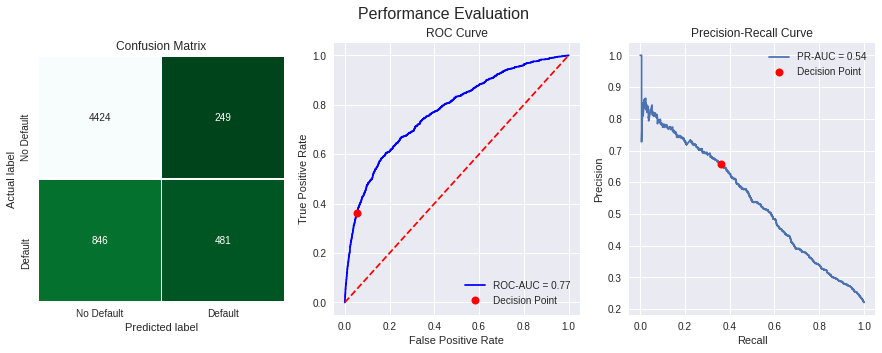

In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', lgbm)
                               ])

lgbm_pipeline.fit(X_train, y_train)
lgbm_perf = performance_evaluation_report(lgbm_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True,
                                          show_pr_curve=True)

# plt.savefig('images/ch9_im4.png', dpi=300)
plt.show()

### There's more

Below we go over the most important hyperparameters of the considered models and show a possible way of tuning them using Randomized Search. With more complex models, the training time is significantly longer than with the basic Decision Tree, so we need to find a balance between the time we want to spend on tuning the hyperparameters and the expected results. Also, bear in mind that changing the values of some parameters (such as learning rate or the number of estimators) can itself influence the training time of the models.

To have the results in a reasonable amount of time, we used the Randomized Search with 100 different sets of hyperparameters for each model (the number of actually fitted models is higher due to cross-validation). Just as in the recipe *Grid Search and Cross-Validation*, we used recall as the criterion for selecting the best model. Additionally, we used the scikit-learn compatible APIs of XGBoost and LightGBM to make the process as easy to follow as possible. For a complete list of hyperparameters and their meaning, please refer to corresponding documentations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
import numpy as np

N_SEARCHES = 100
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

**Random Forest**

When tuning the Random Forest classifier, we look at the following hyperparameters (there are more available for tuning):
* `n_estimators` - the number of decision trees in a forest. The goal is to find a balance between improved accuracy and computational cost.
* `max_features` - the maximum number of features considered for splitting a node. The default is the square root of the number of features. When None, all features are considered.
* `max_depth` - the maximum number of levels in each decision tree
* `min_samples_split` - the minimum number of observations required to split each node. When set to high it may cause underfitting, as the trees will not split enough times.
* `min_samples_leaf` - the minimum number of data points allowed in a leaf. Too small a value might cause overfitting, while large values might prevent the tree from growing and cause underfitting.
* `bootstrap` - whether to use bootstrapping for each tree in the forest

We define the grid below:

In [16]:
import numpy as np
rf_param_grid = {'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
                 'classifier__max_features': ['log2', 'sqrt', None],
                 'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
                 'classifier__min_samples_split': [2, 5, 10],
                 'classifier__min_samples_leaf': np.arange(1, 51, 2, dtype=int),
                 'classifier__bootstrap': [True, False]}

And use the randomized search to tune the classifier:

In [ ]:
rf_rs =  RandomizedSearchCV(rf_pipeline, rf_param_grid, scoring='recall', 
                                       cv=k_fold, #n_jobs=-1,
                                     verbose=1, 
                                       n_iter=N_SEARCHES, random_state=42)

rf_rs.fit(X_train, y_train)

print(f'Best parameters: {rf_rs.best_params_}') 
print(f'Recall (Training set): {rf_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, rf_rs.predict(X_test)):.4f}')

In [ ]:
rf_rs_perf = performance_evaluation_report(rf_rs, X_test, 
                                           y_test, labels=LABELS, 
                                           show_plot=True,
                                           show_pr_curve=True)

**Gradient Boosted Trees**

As Gradient Boosted Trees are also an ensemble method built on top of decision trees, a lot of the parameters are the same as in the case of the Random Forest. The new one is the learning rate, which is used in the gradient descent algorithm to control the rate of descent towards the minimum of the loss function. When tuning the tree manually, we should consider this hyperparameter together with the number of estimators, as reducing the learning rate (the learning is slower), while increasing the number of estimators can increase the computation time significantly.

We define the grid as follows:

In [ ]:
gbt_param_grid = {'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
                  'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
                  'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
                  'classifier__min_samples_split': np.linspace(0.1, 0.5, 12),
                  'classifier__min_samples_leaf': np.arange(1, 51, 2, dtype=int),
                  'classifier__max_features':['log2', 'sqrt', None]}

And run the randomized search:

In [ ]:
gbt_rs =  RandomizedSearchCV(gbt_pipeline, gbt_param_grid, scoring='recall', 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

gbt_rs.fit(X_train, y_train)

print(f'Best parameters: {gbt_rs.best_params_}') 
print(f'Recall (Training set): {gbt_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, gbt_rs.predict(X_test)):.4f}')

In [ ]:
gbt_rs_perf = performance_evaluation_report(gbt_rs, X_test, 
                                            y_test, labels=LABELS, 
                                            show_plot=True,
                                            show_pr_curve=True)

**XGBoost**

The scikit-learn API of XGBoost makes sure that the hyperparameters are named similarly to their equivalents other scikit-learn's classifiers. So the XGBoost native eta hyperparameter is called learning_rate in scikit-learn's API. 

The new hyperparameters we consider for this example are:
* `min_child_weight` - indicates the minimum sum of weights of all observations required in a child. This hyperparameter is used for controlling overfitting. Cross-validation should be used for tuning.
* `colsample_bytree` - indicates the fraction of columns to be randomly sampled for each tree.

We define the grid as:

In [ ]:
xgb_param_grid = {'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
                  'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
                  'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
                  'classifier__min_child_weight': np.arange(1, 8, 1, dtype=int),
                  'classifier__colsample_bytree': np.linspace(0.3, 1, 7)}

For defining ranges of parameters that are restricted (such as colsample_bytree which cannot be higher than 1.0) it is better to use `np.linspace` rather than `np.arange`, because the latter allows for some inconsistencies when the step is defined as floating-point. For example, the last value might be 1.0000000002, which then causes an error while training the classifier.

In [ ]:
xgb_rs =  RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='recall', 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

xgb_rs.fit(X_train, y_train)

print(f'Best parameters: {xgb_rs.best_params_}') 
print(f'Recall (Training set): {xgb_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, xgb_rs.predict(X_test)):.4f}')

In [ ]:
xgb_rs_perf = performance_evaluation_report(xgb_rs, X_test, 
                                            y_test, labels=LABELS, 
                                            show_plot=True,
                                            show_pr_curve=True)

**LightGBM**

We tune the same parameters as in XGBoost, though more is definitely possible and encouraged. The grid is defined as follows:

In [ ]:
lgbm_param_grid = {'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
                   'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
                   'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
                   'classifier__colsample_bytree': np.linspace(0.3, 1, 7)}

In [ ]:
lgbm_rs =  RandomizedSearchCV(lgbm_pipeline, lgbm_param_grid, scoring='recall', 
                              cv=k_fold, n_jobs=-1, verbose=1, 
                              n_iter=N_SEARCHES, random_state=42)

lgbm_rs.fit(X_train, y_train)

print(f'Best parameters: {lgbm_rs.best_params_}') 
print(f'Recall (Training set): {lgbm_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, lgbm_rs.predict(X_test)):.4f}')

In [ ]:
lgbm_rs_perf = performance_evaluation_report(lgbm_rs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True,
                                             show_pr_curve=True)

Below we present a summary of all the classifiers we have considered in the last 3 recipes.

In [ ]:
results_dict = {'decision_tree_baseline': tree_perf,
                'random_forest': rf_perf,
                'random_forest_rs': rf_rs_perf,
                'gradient_boosted_trees': gbt_perf,
                'gradient_boosted_trees_rs': gbt_rs_perf,
                'xgboost': xgb_perf,
                'xgboost_rs': xgb_rs_perf,
                'light_gbm': lgbm_perf,
                'light_gbm_rs': lgbm_rs_perf}

results_comparison = pd.DataFrame(results_dict).T
results_comparison

In [ ]:
results_comparison = pd.read_csv('results_comparison.csv')
results_comparison.rename(columns={'Unnamed: 0': 'model'}, inplace=True)
results_comparison

,model,accuracy,precision,recall,specificity,f1_score,cohens_kappa,roc_auc,pr_auc
0,decision_tree_baseline,0.723333,0.381663,0.404672,0.813824,0.392831,0.213880,0.609528,0.458925
1,random_forest,0.799667,0.595712,0.293142,0.943505,0.392929,0.289244,0.717612,0.478045
2,random_forest_rs,0.809333,0.624829,0.345139,0.941151,0.444660,0.340926,0.732860,0.492833
3,gradient_boosted_trees,0.814333,0.659193,0.332329,0.951209,0.441884,0.344736,0.775486,0.547474
4,gradient_boosted_trees_rs,0.816500,0.651070,0.366993,0.944147,0.469398,0.368741,0.771308,0.538203
5,xgboost,0.815500,0.668712,0.328561,0.953777,0.440627,0.345202,0.774324,0.544790
6,xgboost_rs,0.792833,0.546875,0.369254,0.913118,0.440846,0.319527,0.734802,0.495058
7,light_gbm,0.817500,0.658904,0.362472,0.946715,0.467671,0.368547,0.773868,0.543574
8,light_gbm_rs,0.815667,0.651994,0.357197,0.945859,0.461538,0.361588,0.775173,0.551186


## Using stacking for improved performance

### Getting ready

Make sure you are using `scikit-learn` 0.22 and above for this recipe.

### How to do it...

1. Import the libraries:

In [1]:
import pandas as pd
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold)
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

2. Load and preprocess data:

In [4]:
path='/content/drive/My Drive/Data/credit_card_fraud_new.zip'
import zipfile
import pandas as pd
with zipfile.ZipFile(path) as z:
   with z.open("credit_card_fraud.csv") as f:
      df = pd.read_csv(f, header=0, #delimiter="\t", 
                       sep=',', quotechar='"')
      print(df.head())    # print the first 5 rows

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]


In [5]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
RANDOM_STATE = 42

k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

X = df.copy()
y = X.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

3. Define a list of classifiers to consider:

In [7]:
clf_list = [('dec_tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ('log_reg', LogisticRegression()),
            ('knn', KNeighborsClassifier()),
            ('naive_bayes', GaussianNB())]

4. Iterate over the selected models, fit them to the data and calculate recall using the test set:

In [8]:
for model_tuple in clf_list:
    model = model_tuple[1]
    if 'random_state' in model.get_params().keys():
        model.set_params(random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = metrics.recall_score(y_pred, y_test)
    print(f"{model_tuple[0]}'s recall score: {recall:.4f}")

dec_tree's recall score: 0.7526
log_reg's recall score: 0.8312
knn's recall score: 0.9186
naive_bayes's recall score: 0.0588


5. Define and fit the stacking classifier:

In [10]:
lr = LogisticRegression()
stack_clf = StackingClassifier(clf_list, 
                               final_estimator=lr,
                               cv=k_fold,
                               #n_jobs=-1
                               )
stack_clf.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('dec_tree',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                      

6. Create predictions and evaluate the stacked ensemble:

In [11]:
y_pred = stacking_clf.predict(X_test)
recall = metrics.recall_score(y_pred, y_test)
print(f"The stacked ensemble's recall score: {recall:.4f}")

NameError: ignored

## Investigating the feature importance

### Getting Ready

Please run the code for the *Investigating advanced classifiers* recipe before this one (you do not need to run the *There's more* section).

This recipe requires `scikit-learn` version `0.22`.

### How to do it...

1. Import the libraries:

In [13]:
!pip install eli5

     |████████████████████████████████| 112kB 5.3MB/s 


In [14]:
# from sklearn.inspection import permutation_importance
from sklearn.base import clone 
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


2. Extract the classifier and preprocessor from the pipeline:

In [24]:
# in case we have the fitted grid search object `rf_rs`, we extract the best pipeline
# rf_pipeline = rf_rs.best_estimator_

rf_classifier = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']

# in case we want to manually assign hyperparameters based on previous grid search
# best_parameters =  {'n_estimators': 400, 'min_samples_split': 2, 
#                     'min_samples_leaf': 49, 'max_features': None, 
#                     'max_depth': 20, 'bootstrap': True, 'random_state': 42}
# rf_classifier = rf_classifier.set_params(**best_parameters)

3. Recover feature names from the preprocessing transformer and transform the training data:

In [25]:
feat_names = preprocessor.named_transformers_['categorical'] \
                         .named_steps['onehot'] \
                         .get_feature_names(
    input_features=cat_features
)
feat_names = np.r_[num_features, feat_names]

X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train), 
    columns=feat_names
)
X_train_preprocessed

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,sex_Male,education_Graduate school,education_High school,education_Others,marriage_Married,marriage_Others,payment_status_sep_Payment delayed 1 month,payment_status_sep_Unknown,payment_status_sep_Payed duly,payment_status_sep_Payment delayed 3 months,payment_status_sep_Payment delayed 4 months,payment_status_sep_Payment delayed 6 months,payment_status_sep_Payment delayed 5 months,payment_status_sep_Payment delayed 8 months,payment_status_sep_Payment delayed 7 months,payment_status_aug_Payed duly,payment_status_aug_Unknown,payment_status_aug_Payment delayed 3 months,payment_status_aug_Payment delayed 1 month,payment_status_aug_Payment delayed 4 months,payment_status_aug_Payment delayed 5 months,payment_status_aug_Payment delayed 7 months,payment_status_aug_Payment delayed 6 months,payment_status_aug_Payment delayed 8 months,payment_status_jul_Payed duly,payment_status_jul_Unknown,payment_status_jul_Payment delayed 2 months,payment_status_jul_Payment delayed 4 months,payment_status_jul_Payment delayed 7 months,payment_status_jul_Payment delayed 6 months,payment_status_jul_Payment delayed 5 months,payment_status_jul_Payment delayed 1 month,payment_status_jul_Payment delayed 8 months,payment_status_jun_Unknown,payment_status_jun_Payed duly,payment_status_jun_Payment delayed 3 months,payment_status_jun_Payment delayed 7 months,payment_status_jun_Payment delayed 4 months,payment_status_jun_Payment delayed 5 months,payment_status_jun_Payment delayed 1 month,payment_status_jun_Payment delayed 8 months,payment_status_jun_Payment delayed 6 months,payment_status_may_Payed duly,payment_status_may_Payment delayed 2 months,payment_status_may_Payment delayed 7 months,payment_status_may_Payment delayed 5 months,payment_status_may_Payment delayed 4 months,payment_status_may_Payment delayed 3 months,payment_status_may_Payment delayed 6 months,payment_status_may_Payment delayed 8 months,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 8 months
0,160000.0,33.0,161771.0,172632.0,168541.0,164310.0,162681.0,163005.0,15000.0,0.0,0.0,6100.0,12300.0,6100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,150000.0,34.0,0.0,53.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000.0,50.0,10171.0,8150.0,8446.0,8067.0,8227.0,8400.0,2.0,1281.0,1134.0,294.0,305.0,1000.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,220000.0,29.0,206879.0,211037.0,215139.0,218513.0,131660.0,134346.0,9100.0,9000.0,7887.0,4800.0,4900.0,6000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,310000.0,32.0,0.0,0.0,326.0,326.0,-235.0,-235.0,0.0,326.0,0.0,0.0,0.0,1200.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

4. Extract the default feature importance and calculate the cumulative importance:

In [26]:
rf_feat_imp = pd.DataFrame(rf_classifier.feature_importances_,
                           index=feat_names,
                           columns=['mdi'])
rf_feat_imp = rf_feat_imp.sort_values('mdi', ascending=False)
rf_feat_imp['cumul_importance_mdi'] = np.cumsum(rf_feat_imp.mdi)
rf_feat_imp

,mdi,cumul_importance_mdi
age,6.846780e-02,0.068468
limit_bal,6.649377e-02,0.134962
bill_statement_sep,6.223409e-02,0.197196
bill_statement_aug,5.679779e-02,0.253993
bill_statement_jul,5.441694e-02,0.308410
...,...,...
payment_status_may_Payment delayed 8 months,6.866330e-06,0.999990
payment_status_apr_Payment delayed 8 months,4.815817e-06,0.999995
payment_status_jun_Payment delayed 1 month,2.665557e-06,0.999998
payment_status_jul_Payment delayed 1 month,2.013225e-06,1.000000


5. Define a function for plotting top X features in terms of their importance:

In [27]:
def plot_most_important_features(feat_imp, method='MDI', 
                                 n_features=10, bottom=False):
    '''
    Function for plotting the top/bottom x features in terms of their importance.
    
    Parameters
    ----------
    feat_imp : pd.Series
        A pd.Series with calculated feature importances
    method : str
        A string representing the method of calculating the importances.
        Used for the title of the plot.
    n_features : int
        Number of top/bottom features to plot
    bottom : boolean
        Indicates if the plot should contain the bottom feature importances.
    
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        Ax cointaining the plot
    '''
    
    if bottom:
        indicator = 'Bottom'
        feat_imp = feat_imp.sort_values(ascending=True)
    else:
        indicator = 'Top'
        feat_imp = feat_imp.sort_values(ascending=False)
        
    ax = feat_imp.head(n_features).plot.barh()
    ax.invert_yaxis()
    ax.set(title=('Feature importance - '
                  f'{method} ({indicator} {n_features})'), 
           xlabel='Importance', 
           ylabel='Feature')
    
    return ax

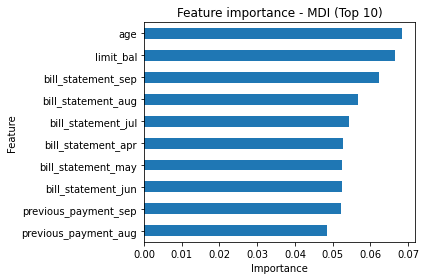

In [28]:
plot_most_important_features(rf_feat_imp.mdi, 
                             method='MDI')

plt.tight_layout()
#plt.savefig('images/ch9_im7.png', dpi=300)
plt.show()

### Feature important by correlation

In [87]:
X_train_preprocessed

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,sex_Male,education_Graduate school,education_High school,education_Others,marriage_Married,marriage_Others,payment_status_sep_Payment delayed 1 month,payment_status_sep_Unknown,payment_status_sep_Payed duly,payment_status_sep_Payment delayed 3 months,payment_status_sep_Payment delayed 4 months,payment_status_sep_Payment delayed 6 months,payment_status_sep_Payment delayed 5 months,payment_status_sep_Payment delayed 8 months,payment_status_sep_Payment delayed 7 months,payment_status_aug_Payed duly,payment_status_aug_Unknown,payment_status_aug_Payment delayed 3 months,payment_status_aug_Payment delayed 1 month,payment_status_aug_Payment delayed 4 months,payment_status_aug_Payment delayed 5 months,payment_status_aug_Payment delayed 7 months,payment_status_aug_Payment delayed 6 months,payment_status_aug_Payment delayed 8 months,payment_status_jul_Payed duly,payment_status_jul_Unknown,payment_status_jul_Payment delayed 2 months,payment_status_jul_Payment delayed 4 months,payment_status_jul_Payment delayed 7 months,payment_status_jul_Payment delayed 6 months,payment_status_jul_Payment delayed 5 months,payment_status_jul_Payment delayed 1 month,payment_status_jul_Payment delayed 8 months,payment_status_jun_Unknown,payment_status_jun_Payed duly,payment_status_jun_Payment delayed 3 months,payment_status_jun_Payment delayed 7 months,payment_status_jun_Payment delayed 4 months,payment_status_jun_Payment delayed 5 months,payment_status_jun_Payment delayed 1 month,payment_status_jun_Payment delayed 8 months,payment_status_jun_Payment delayed 6 months,payment_status_may_Payed duly,payment_status_may_Payment delayed 2 months,payment_status_may_Payment delayed 7 months,payment_status_may_Payment delayed 5 months,payment_status_may_Payment delayed 4 months,payment_status_may_Payment delayed 3 months,payment_status_may_Payment delayed 6 months,payment_status_may_Payment delayed 8 months,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 8 months
0,160000.0,33.0,161771.0,172632.0,168541.0,164310.0,162681.0,163005.0,15000.0,0.0,0.0,6100.0,12300.0,6100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,150000.0,34.0,0.0,53.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000.0,50.0,10171.0,8150.0,8446.0,8067.0,8227.0,8400.0,2.0,1281.0,1134.0,294.0,305.0,1000.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,220000.0,29.0,206879.0,211037.0,215139.0,218513.0,131660.0,134346.0,9100.0,9000.0,7887.0,4800.0,4900.0,6000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,310000.0,32.0,0.0,0.0,326.0,326.0,-235.0,-235.0,0.0,326.0,0.0,0.0,0.0,1200.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

In [ ]:
y_train_new=y_train.reset_index(drop=True)
y_train_new

In [ ]:
newdata_concat=pd.concat([X_train_preprocessed,y_train_new],axis=1)
newdata_concat

In [88]:
newdata_concat.corr()['default_payment_next_month'].sort_values(ascending=False)[:20]

default_payment_next_month                     1.000000
payment_status_jul_Payment delayed 2 months    0.272969
payment_status_may_Payment delayed 2 months    0.242551
payment_status_apr_Payment delayed 2 months    0.220164
payment_status_sep_Payment delayed 3 months    0.133628
payment_status_sep_Payment delayed 1 month     0.111514
payment_status_aug_Payment delayed 3 months    0.103804
payment_status_apr_Payment delayed 3 months    0.076733
payment_status_jun_Payment delayed 3 months    0.072221
payment_status_may_Payment delayed 3 months    0.068836
payment_status_jun_Payment delayed 7 months    0.061899
payment_status_may_Payment delayed 7 months    0.059571
payment_status_apr_Payment delayed 7 months    0.053370
payment_status_sep_Payment delayed 4 months    0.051461
payment_status_jun_Payment delayed 4 months    0.047639
payment_status_apr_Payment delayed 4 months    0.047338
sex_Male                                       0.043848
payment_status_may_Payment delayed 4 months    0

6. Plot the cumulative importance of the features:

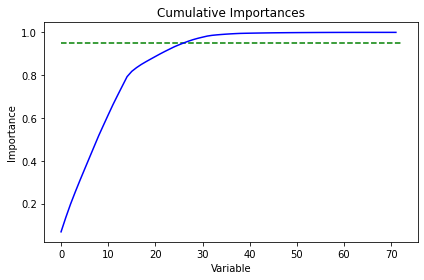

In [29]:
x_values = range(len(feat_names))

fig, ax = plt.subplots()

ax.plot(x_values, rf_feat_imp.cumul_importance_mdi, 'b-')
ax.hlines(y = 0.95, xmin=0, xmax=len(x_values), 
          color = 'g', linestyles = 'dashed')
ax.set(title='Cumulative Importances', 
       xlabel='Variable', 
       ylabel='Importance')

plt.tight_layout()
#plt.savefig('images/ch9_im8.png', dpi=300)
plt.show()

In [30]:
print(f'Top 10 features account for {100 * rf_feat_imp.head(10).mdi.sum():.2f}% of the total importance.')
print(f'Top {rf_feat_imp[rf_feat_imp.cumul_importance_mdi <= 0.95].shape[0]} features account for 95% of importance.')

Top 10 features account for 56.68% of the total importance.
Top 26 features account for 95% of importance.


Here are the disadvantages of this approach:
- Biased—It tends to inflate the importance of continuous (numerical) features or
high-cardinality categorical variables. This can sometimes lead to absurd cases,
whereby an additional random variable (unrelated to the problem at hand)
scores high in the feature importance ranking.
- Impurity-based importances are calculated on the basis of the training set and do
not reflect the model's ability to generalize to unseen data.

7. Calculate and plot permutation importance:

In [31]:
perm = PermutationImportance(rf_classifier, n_iter = 25, 
                             random_state=42)
perm.fit(X_train_preprocessed, y_train)
rf_feat_imp['permutation'] = perm.feature_importances_

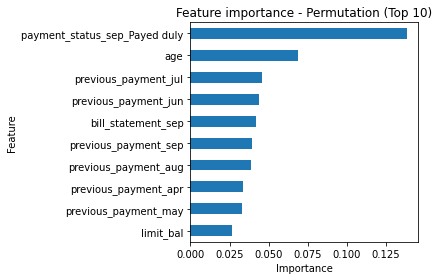

In [32]:
plot_most_important_features(rf_feat_imp.permutation, 
                             method='Permutation')

plt.tight_layout()
#plt.savefig('images/ch9_im9.png', dpi=300)
plt.show()

In [95]:
df.corr()['default_payment_next_month'].abs().sort_values(ascending=False)

default_payment_next_month    1.000000
limit_bal                     0.153520
previous_payment_sep          0.072929
previous_payment_aug          0.058579
previous_payment_jun          0.056827
previous_payment_jul          0.056250
previous_payment_may          0.055124
previous_payment_apr          0.053183
bill_statement_sep            0.019644
age                           0.014491
bill_statement_aug            0.014193
bill_statement_jul            0.014076
bill_statement_jun            0.010156
bill_statement_may            0.006760
bill_statement_apr            0.005372
Name: default_payment_next_month, dtype: float64

In [91]:
df.corr()['default_payment_next_month'].sort_values(ascending=False)

default_payment_next_month    1.000000
age                           0.014491
bill_statement_apr           -0.005372
bill_statement_may           -0.006760
bill_statement_jun           -0.010156
bill_statement_jul           -0.014076
bill_statement_aug           -0.014193
bill_statement_sep           -0.019644
previous_payment_apr         -0.053183
previous_payment_may         -0.055124
previous_payment_jul         -0.056250
previous_payment_jun         -0.056827
previous_payment_aug         -0.058579
previous_payment_sep         -0.072929
limit_bal                    -0.153520
Name: default_payment_next_month, dtype: float64

8. Define a function for calculating the drop-column feature importance:

In [33]:
def drop_col_feat_imp(model, X, y, random_state = 42):
    '''
    Function for calculating the drop column feature importance.
    
    Parameters
    ----------
    model : scikit-learn's model
        Object representing the estimator with selected hyperparameters.
    X : pd.DataFrame
        Features for training the model
    y : pd.Series
        The target
    random_state : int
        Random state for reproducibility
        
    Returns
    -------
    importances : list
        List containing the calculated feature importances in the order of appearing in X
    
    '''
    
    model_clone = clone(model)
    model_clone.random_state = random_state
    model_clone.fit(X, y)
    benchmark_score = model_clone.score(X, y)
    
    importances = []
    
    for col in X.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X.drop(col, axis = 1), y)
        drop_col_score = model_clone.score(X.drop(col, axis = 1), 
                                           y)
        importances.append(benchmark_score - drop_col_score)
    
    return importances

9. Calculate and plot the drop-column feature importance:

In [34]:
rf_feat_imp['drop_column'] = drop_col_feat_imp(
    rf_classifier, 
    X_train_preprocessed, 
    y_train, 
    random_state = 42
)

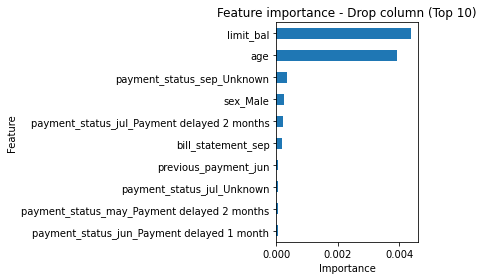

In [35]:
plot_most_important_features(rf_feat_imp.drop_column, 
                             method='Drop column')

plt.tight_layout()
#plt.savefig('images/ch9_im10.png', dpi=300)
plt.show()

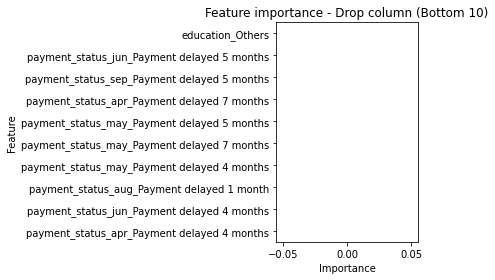

In [36]:
plot_most_important_features(rf_feat_imp.drop_column, 
                             method='Drop column', 
                             bottom=True)

plt.tight_layout()
#plt.savefig('images/ch9_im11.png', dpi=300)
plt.show()

## Investigating different approaches to handling imbalanced data

### How to do it...

1. Import the libraries:

In [98]:
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
#from chapter_9_utils import performance_evaluation_report

2. Load and prepare data:

In [99]:
path='/content/drive/My Drive/Data/credit_card_fraud_new.zip'
import zipfile
import pandas as pd
with zipfile.ZipFile(path) as z:
   with z.open("credit_card_fraud.csv") as f:
      df = pd.read_csv(f, header=0, #delimiter="\t", 
                       sep=',', quotechar='"')
      print(df.head())    # print the first 5 rows

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]


In [100]:
#df = pd.read_csv('../Datasets/credit_card_fraud.csv')

X = df.copy()
y = X.pop('Class')

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [101]:
y.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

3. Train the baseline model:

In [42]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

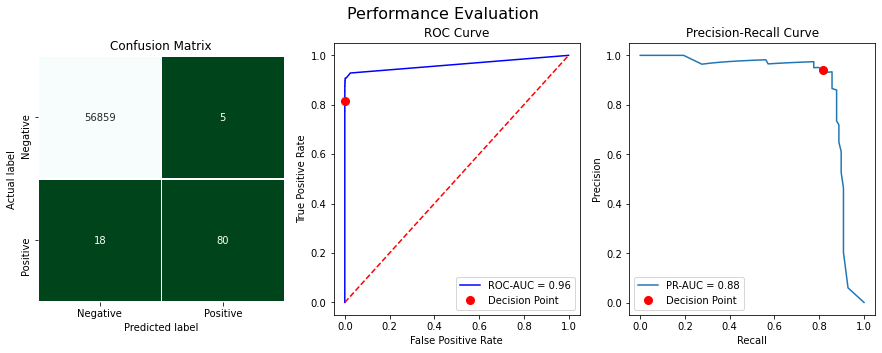

In [43]:
rf_perf = performance_evaluation_report(rf, X_test, y_test, 
                                        show_plot=True, 
                                        show_pr_curve=True)

In [44]:
rf_perf

{'accuracy': 0.9995962220427653,
 'cohens_kappa': 0.8741157481811475,
 'f1_score': 0.8743169398907105,
 'pr_auc': 0.8788377674073098,
 'precision': 0.9411764705882353,
 'recall': 0.8163265306122449,
 'roc_auc': 0.9630272515590367,
 'specificity': 0.9999120709060214}

####4. Undersample the data and train a Random Forest Classifier:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The new class proportions are: {0: 394, 1: 394}


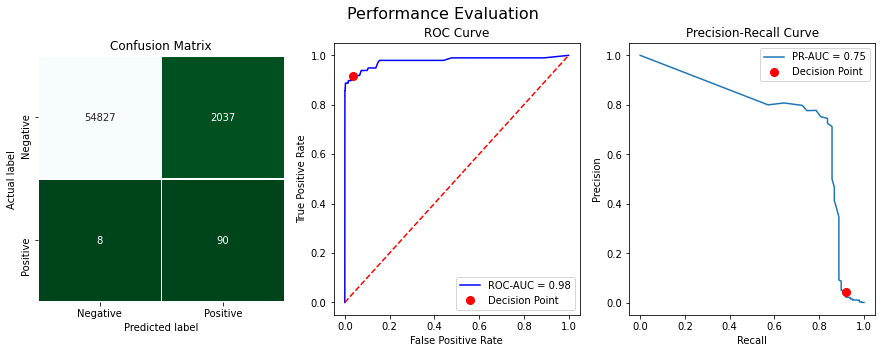

In [45]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_rus))}')

rf.fit(X_rus, y_rus)
rf_rus_perf = performance_evaluation_report(rf, X_test, y_test, 
                                            show_plot=True, 
                                            show_pr_curve=True)

In [46]:
rf_rus_perf

{'accuracy': 0.9640988729328324,
 'cohens_kappa': 0.0778656661966407,
 'f1_score': 0.08089887640449436,
 'pr_auc': 0.753825993338084,
 'precision': 0.04231311706629055,
 'recall': 0.9183673469387755,
 'roc_auc': 0.9776978619951074,
 'specificity': 0.964177687113112}

####5. Oversample the data and train a Random Forest Classifier:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The new class proportions are: {0: 227451, 1: 227451}


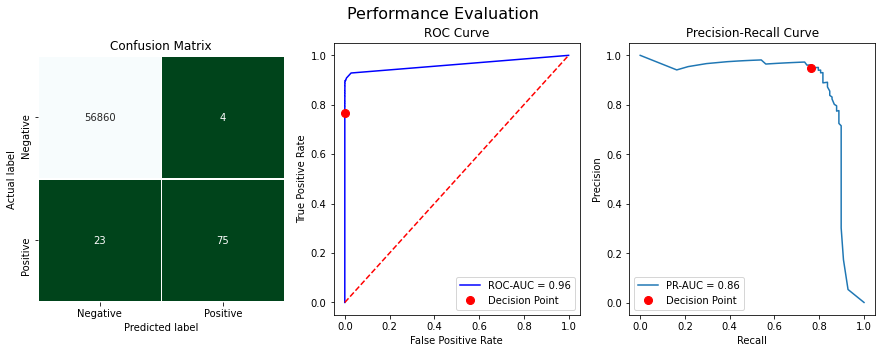

In [47]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_ros))}')

rf.fit(X_ros, y_ros)
rf_ros_perf = performance_evaluation_report(rf, X_test, y_test, 
                                            show_plot=True, 
                                            show_pr_curve=True)


In [48]:
rf_ros_perf

{'accuracy': 0.9995259997893332,
 'cohens_kappa': 0.8472229975990361,
 'f1_score': 0.8474576271186441,
 'pr_auc': 0.8637313842580973,
 'precision': 0.9493670886075949,
 'recall': 0.7653061224489796,
 'roc_auc': 0.9628214257002745,
 'specificity': 0.9999296567248172}

####6. Oversample using SMOTE:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The new class proportions are: {0: 227451, 1: 227451}


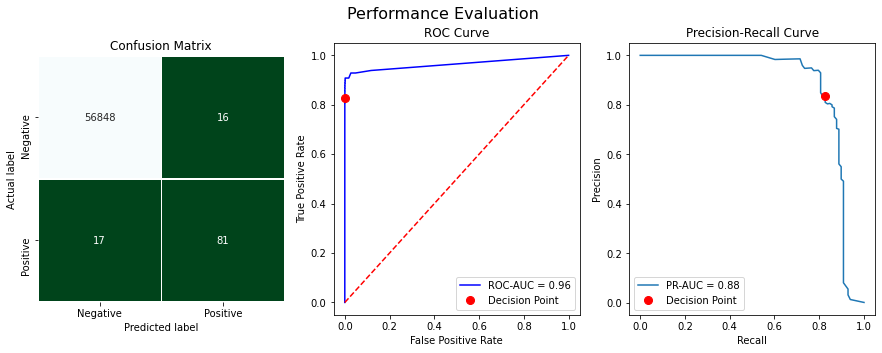

In [49]:
X_smote, y_smote = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_smote))}')
rf.fit(X_smote, y_smote)
rf_smote_perf = performance_evaluation_report(rf, X_test, y_test, 
                                              show_plot=True, 
                                              show_pr_curve=True)


In [50]:
rf_smote_perf

{'accuracy': 0.999420666409185,
 'cohens_kappa': 0.8304790749544261,
 'f1_score': 0.8307692307692307,
 'pr_auc': 0.8764981229088987,
 'precision': 0.8350515463917526,
 'recall': 0.826530612244898,
 'roc_auc': 0.9644232605112952,
 'specificity': 0.9997186268992684}

####7. Oversample using ADASYN:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The new class proportions are: {0: 227451, 1: 227346}


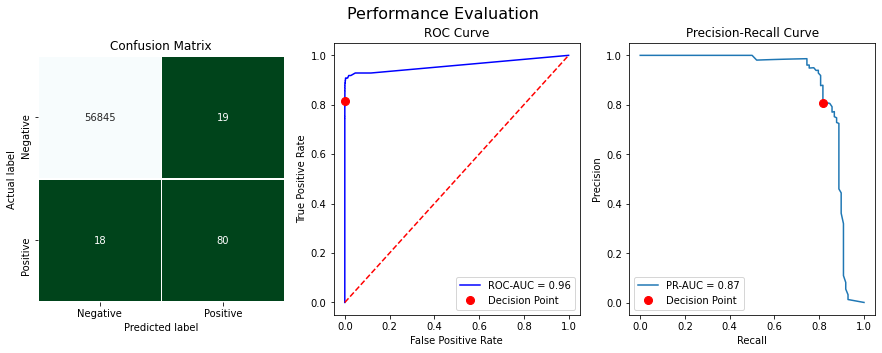

In [51]:
X_adasyn, y_adasyn = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_adasyn))}')
rf.fit(X_adasyn, y_adasyn)
rf_adasyn_perf = performance_evaluation_report(rf, X_test, y_test, 
                                               show_plot=True, 
                                               show_pr_curve=True)


In [52]:
rf_adasyn_perf

{'accuracy': 0.9993504441557529,
 'cohens_kappa': 0.8118574090059819,
 'f1_score': 0.8121827411167513,
 'pr_auc': 0.8738106319824308,
 'precision': 0.8080808080808081,
 'recall': 0.8163265306122449,
 'roc_auc': 0.9594939375581408,
 'specificity': 0.9996658694428813}

####8. Use sample weights in the Random Forest Classifier:

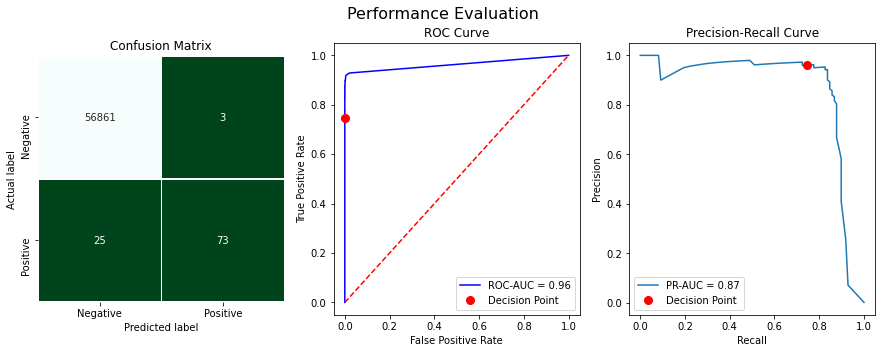

In [53]:
rf_cw = RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight='balanced',
                               n_jobs=-1)
rf_cw.fit(X_train, y_train)
rf_cw_perf = performance_evaluation_report(rf_cw, X_test, y_test, 
                                           show_plot=True, 
                                           show_pr_curve=True)


In [54]:
rf_cw_perf

{'accuracy': 0.9995084442259752,
 'cohens_kappa': 0.8388382469262846,
 'f1_score': 0.839080459770115,
 'pr_auc': 0.865417725156999,
 'precision': 0.9605263157894737,
 'recall': 0.7448979591836735,
 'roc_auc': 0.9632954352956715,
 'specificity': 0.9999472425436128}

### There's more

1. Import the library:

In [55]:
from imblearn.ensemble import BalancedRandomForestClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24

####2. Train the `BalancedRandomForestClassifier`:

In [104]:
y_train.value_counts(normalize=True)

0    0.998271
1    0.001729
Name: Class, dtype: float64

In [96]:
print(X_train.shape)
print(y_train.shape)

(24000, 23)
(24000,)


In [103]:
balanced_rf = BalancedRandomForestClassifier(
    random_state=RANDOM_STATE
)

balanced_rf.fit(X_train, y_train)
balanced_rf_perf = performance_evaluation_report(balanced_rf, 
                                                 X_test, y_test, 
                                                 show_plot=True, 
                                                 show_pr_curve=True)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

####3. Train the `BalancedRandomForestClassifier` with balanced classes:

In [102]:
balanced_rf_cw = BalancedRandomForestClassifier(
    random_state=RANDOM_STATE, 
    class_weight='balanced',
    n_jobs=-1
)

balanced_rf_cw.fit(X_train, y_train)
balanced_rf_cw_perf = performance_evaluation_report(balanced_rf_cw, 
                                                    X_test, y_test, 
                                                    show_plot=True, 
                                                    show_pr_curve=True)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

4. Group the performance results into a DataFrame:

In [ ]:
performance_results = {'random_forest': rf_perf,
                       'undersampled rf': rf_rus_perf,
                       'oversampled_rf': rf_ros_perf,
                       'smote': rf_smote_perf,
                       'adasyn': rf_adasyn_perf,
                       'random_forest_cw': rf_cw_perf,
                       'balanced_random_forest': balanced_rf_perf,
                       'balanced_random_forest_cw': balanced_rf_cw_perf}
pd.DataFrame(performance_results).T

## Bayesian Hyperparameter Optimization

### How to do it...

1. Load the libraries:

In [105]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import (cross_val_score, 
                                     StratifiedKFold)
from lightgbm import LGBMClassifier
#from chapter_9_utils import performance_evaluation_report
import pickle

2. Define parameters for later use:

In [106]:
N_FOLDS = 5
MAX_EVALS = 200

3. Load and prepare the data:

In [111]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [108]:
#df = pd.read_csv('../Datasets/credit_card_fraud.csv')

X = df.copy()
y = X.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

4. Define the objective function:

In [109]:
def objective(params, n_folds = N_FOLDS, random_state=42):
    
    model = LGBMClassifier(**params)
    model.set_params(random_state=random_state)
    
    k_fold = StratifiedKFold(n_folds, shuffle=True, 
                             random_state=random_state)
    
    metrics = cross_val_score(model, X_train, y_train, 
                              cv=k_fold, scoring='recall')
    loss = -1 * metrics.mean()
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

5. Define the search space:

In [110]:
lgbm_param_grid = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'max_depth': hp.choice('max_depth', [-1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 
                                               300, 750, 1000]),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
}

6. Run the Bayesian optimization:

In [ ]:
trials = Trials()
best_set = fmin(fn= objective,
                space= lgbm_param_grid,
                algo= tpe.suggest,
                max_evals = MAX_EVALS,
                trials= trials)

  8%|▊         | 15/200 [04:05<45:31, 14.77s/it, best loss: -0.9441739694904253]

In [ ]:
# load if already finished the search
#best_set = pickle.load(open('best_set.p', 'rb'))
best_set

{'boosting_type': 1,
 'colsample_bytree': 0.8861225641638096,
 'is_unbalance': 0,
 'learning_rate': 0.193440600772047,
 'max_depth': 6,
 'n_estimators': 0}

7. Define the dictionaries for mapping the results to hyperparameter values:

In [ ]:
boosting_type = {0: 'gbdt', 1: 'dart', 2: 'goss'}
max_depth = {0: -1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 
             6: 7, 7: 8, 8: 9, 9: 10}
n_estimators = {0: 10, 1: 50, 2: 100, 3: 300, 4: 750, 5: 1000}
is_unbalance = {0: True, 1: False}

8. Fit a model using the best hyperparameters:

In [ ]:
lgbm_param_grid = {'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
                   'max_depth': hp.choice('max_depth', [-1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                   'n_estimators': hp.choice('n_estimators', [10, 50, 100, 300, 750, 1000]),
                   'is_unbalance': hp.choice('is_unbalance', [True, False]),
                   'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
                   'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
                  }

In [ ]:
best_lgbm = LGBMClassifier(
    boosting_type = boosting_type[best_set['boosting_type']], 
    max_depth = max_depth[best_set['max_depth']], 
    n_estimators = n_estimators[best_set['n_estimators']], 
    is_unbalance = is_unbalance[best_set['is_unbalance']],
    colsample_bytree = best_set['colsample_bytree'], 
    learning_rate = best_set['learning_rate']
)
best_lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', class_weight=None,
               colsample_bytree=0.8861225641638096, importance_type='split',
               is_unbalance=True, learning_rate=0.193440600772047, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

9. Evaluate on the test set:

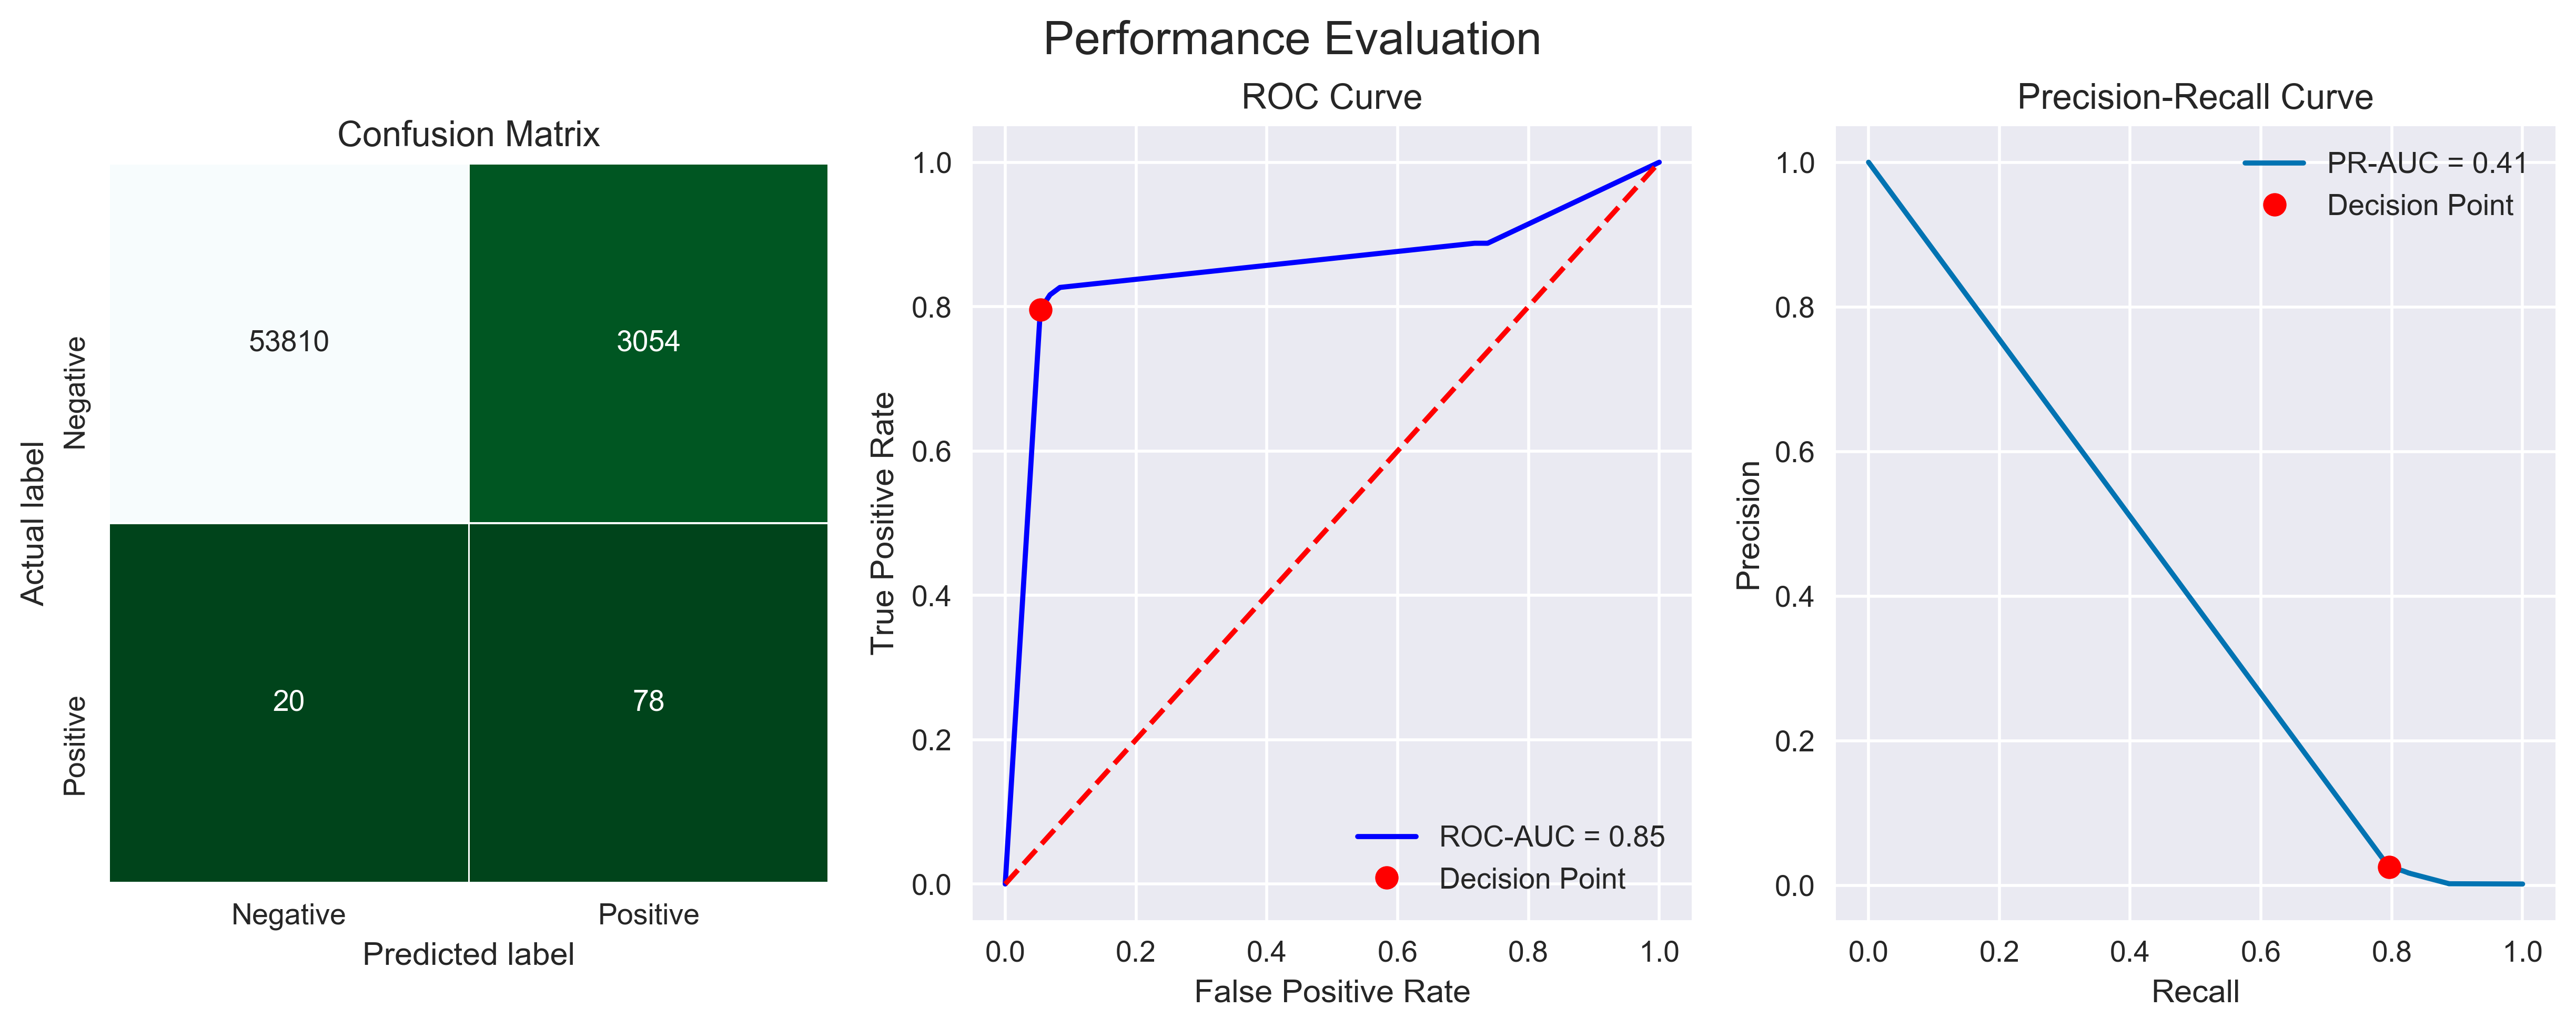

In [ ]:
_ = performance_evaluation_report(best_lgbm, X_test, y_test, 
                                  show_plot=True, 
                                  show_pr_curve=True)

plt.savefig('images/ch9_im13.png', dpi=300)
plt.show()

### There's more

1. Import the libraries:

In [ ]:
from pandas.io.json import json_normalize
from hyperopt.pyll.stochastic import sample

In [ ]:
import pickle 
trials = pickle.load(open("trials_final.p", "rb"))

2. Parse all the information from `trials.results` into a DataFrame:

In [ ]:
results_df = pd.DataFrame(trials.results)
params_df = json_normalize(results_df['params'])

results_df = pd.concat([results_df.drop('params', axis=1), params_df], 
                       axis=1)
results_df['iteration'] = np.arange(len(results_df)) + 1
results_df.sort_values('loss')

,loss,status,boosting_type,colsample_bytree,is_unbalance,learning_rate,max_depth,n_estimators,iteration
95,-0.931386,ok,dart,0.886123,True,0.193441,7,10,96
69,-0.918663,ok,dart,0.778898,True,0.235866,4,10,70
115,-0.913632,ok,dart,0.996660,True,0.285100,2,10,116
168,-0.911165,ok,gbdt,0.874630,True,0.105400,7,10,169
61,-0.910970,ok,dart,0.761668,True,0.060268,7,750,62
...,...,...,...,...,...,...,...,...,...
145,-0.119572,ok,dart,0.677408,True,0.204165,7,750,146
13,-0.091399,ok,gbdt,0.761404,False,0.161734,-1,750,14
60,-0.078481,ok,goss,0.848763,False,0.189308,4,50,61
164,-0.032911,ok,dart,0.593780,False,0.185348,-1,100,165


3. Draw sample from the selected distribution of `colsample_bytree`:

In [ ]:
colsample_bytree_dist = []

for _ in range(10000):
    x = sample(lgbm_param_grid['colsample_bytree'])
    colsample_bytree_dist.append(x)

4. Plot the results:

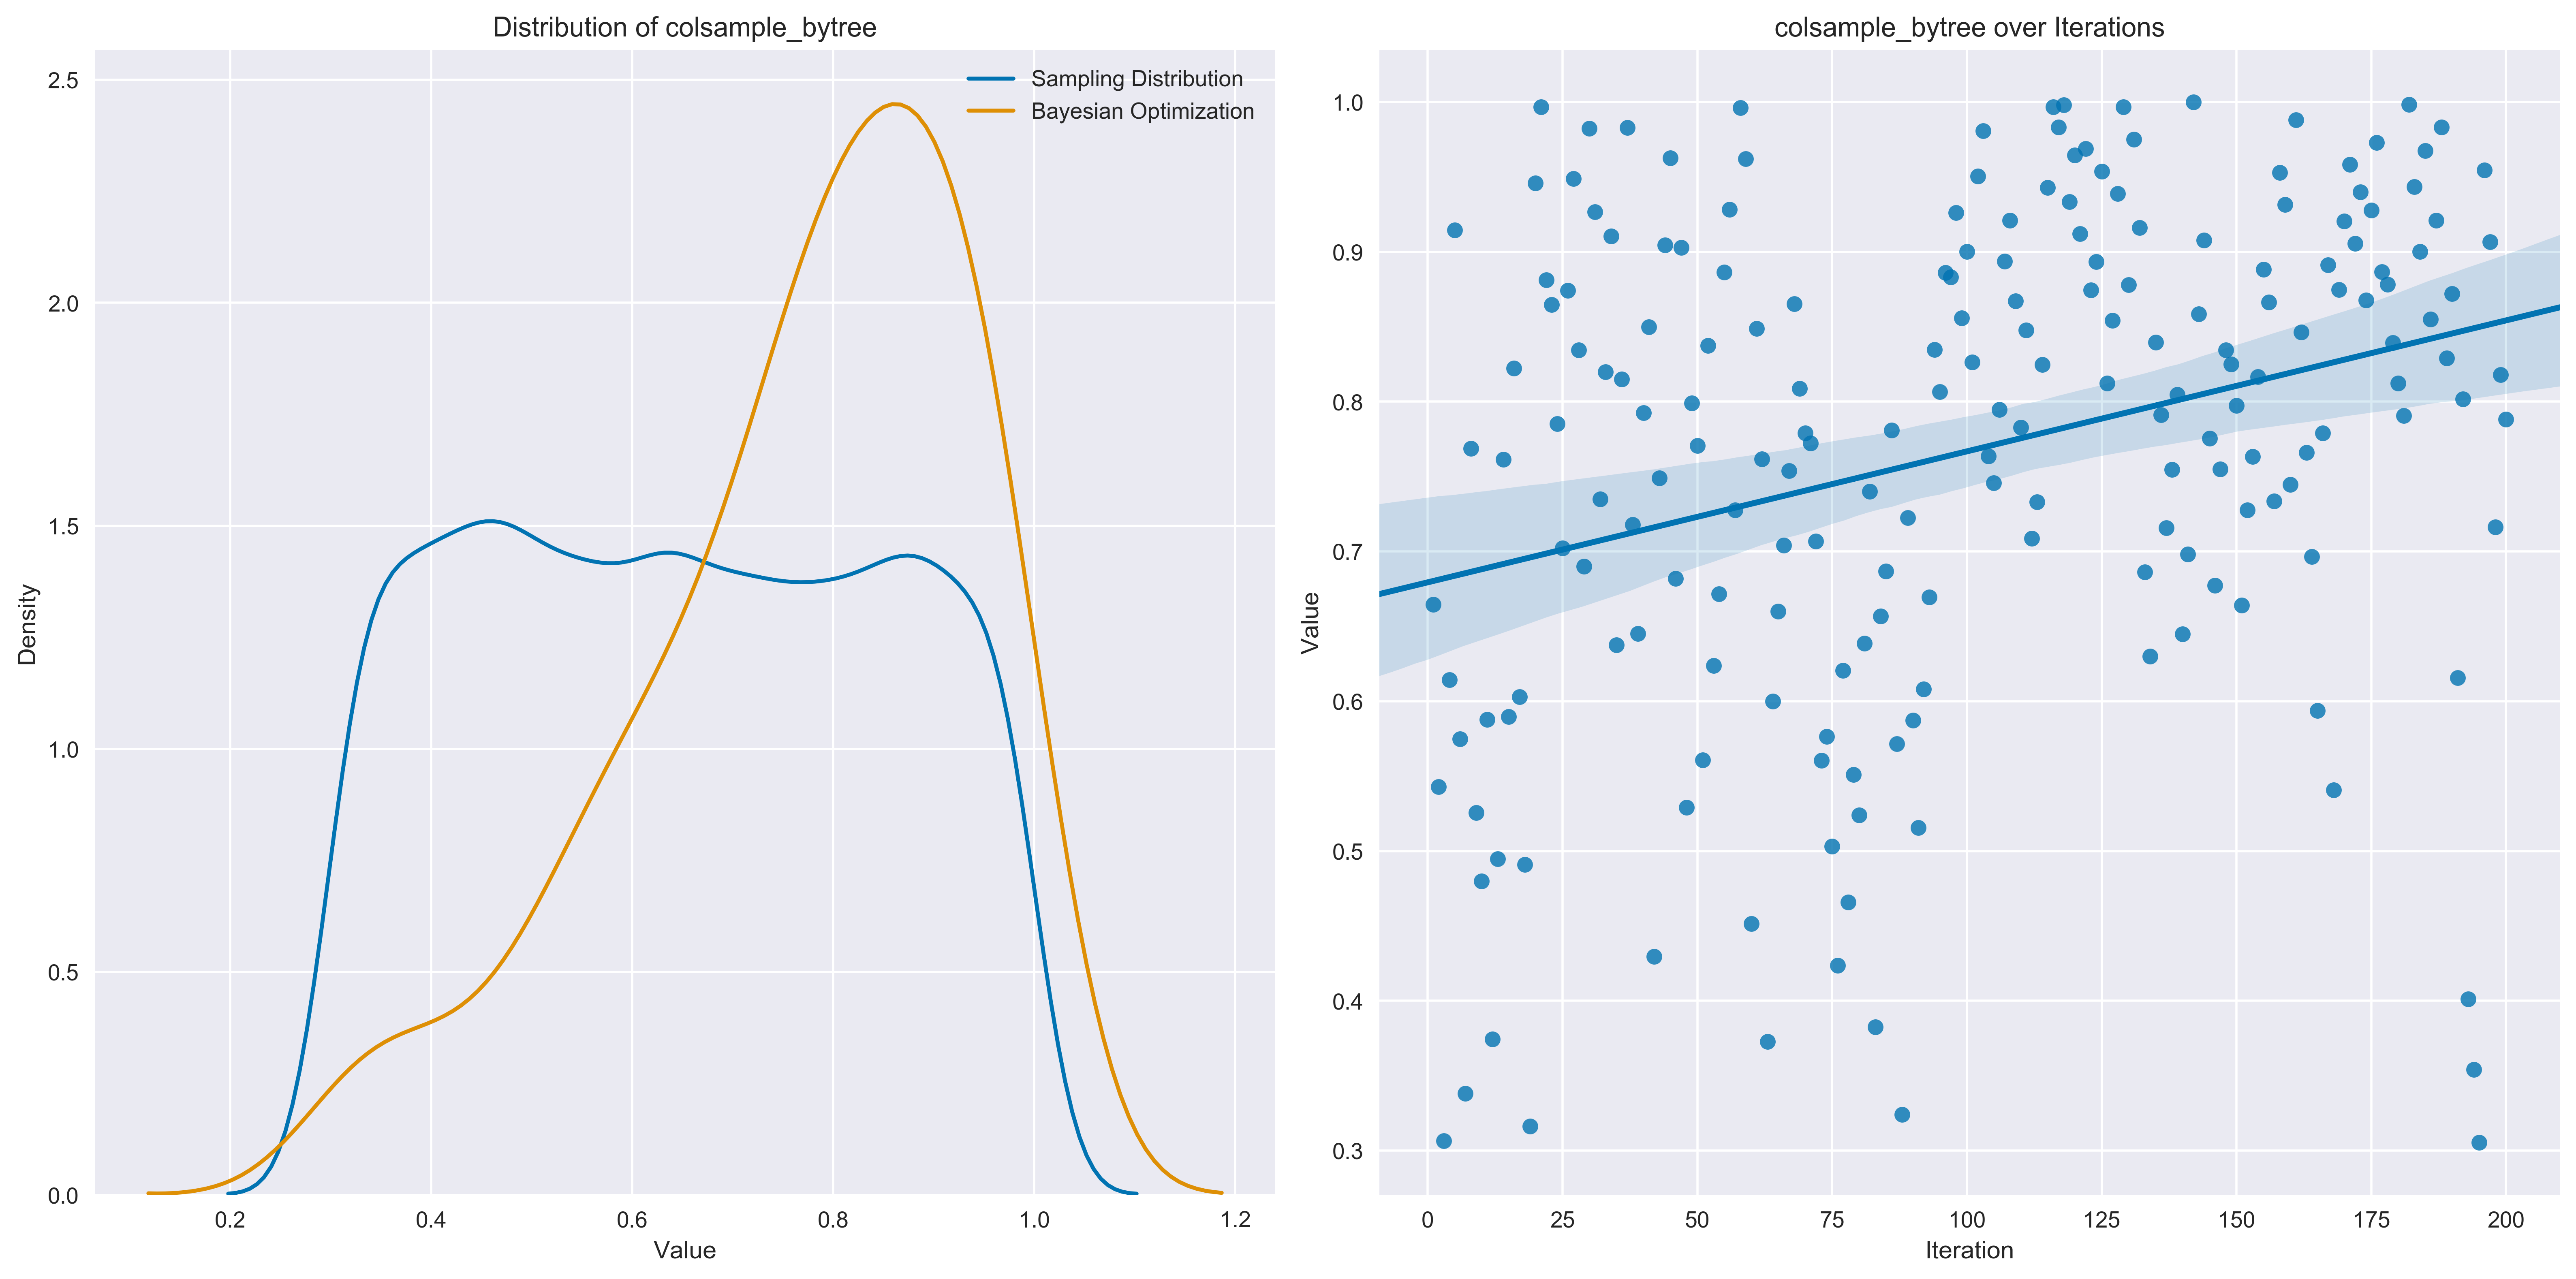

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

sns.kdeplot(colsample_bytree_dist, 
            label='Sampling Distribution', 
            ax=ax[0])
sns.kdeplot(results_df['colsample_bytree'], 
            label='Bayesian Optimization', 
            ax=ax[0])
ax[0].set(title='Distribution of colsample_bytree', 
          xlabel='Value',
          ylabel='Density')
ax[0].legend()

sns.regplot('iteration', 'colsample_bytree', 
            data=results_df, ax=ax[1])
ax[1].set(title='colsample_bytree over Iterations', 
          xlabel='Iteration', 
          ylabel='Value')

plt.tight_layout()
plt.savefig('images/ch9_im14.png', dpi=300)
plt.show()

5. Plot the distribution of `n_estimators`:

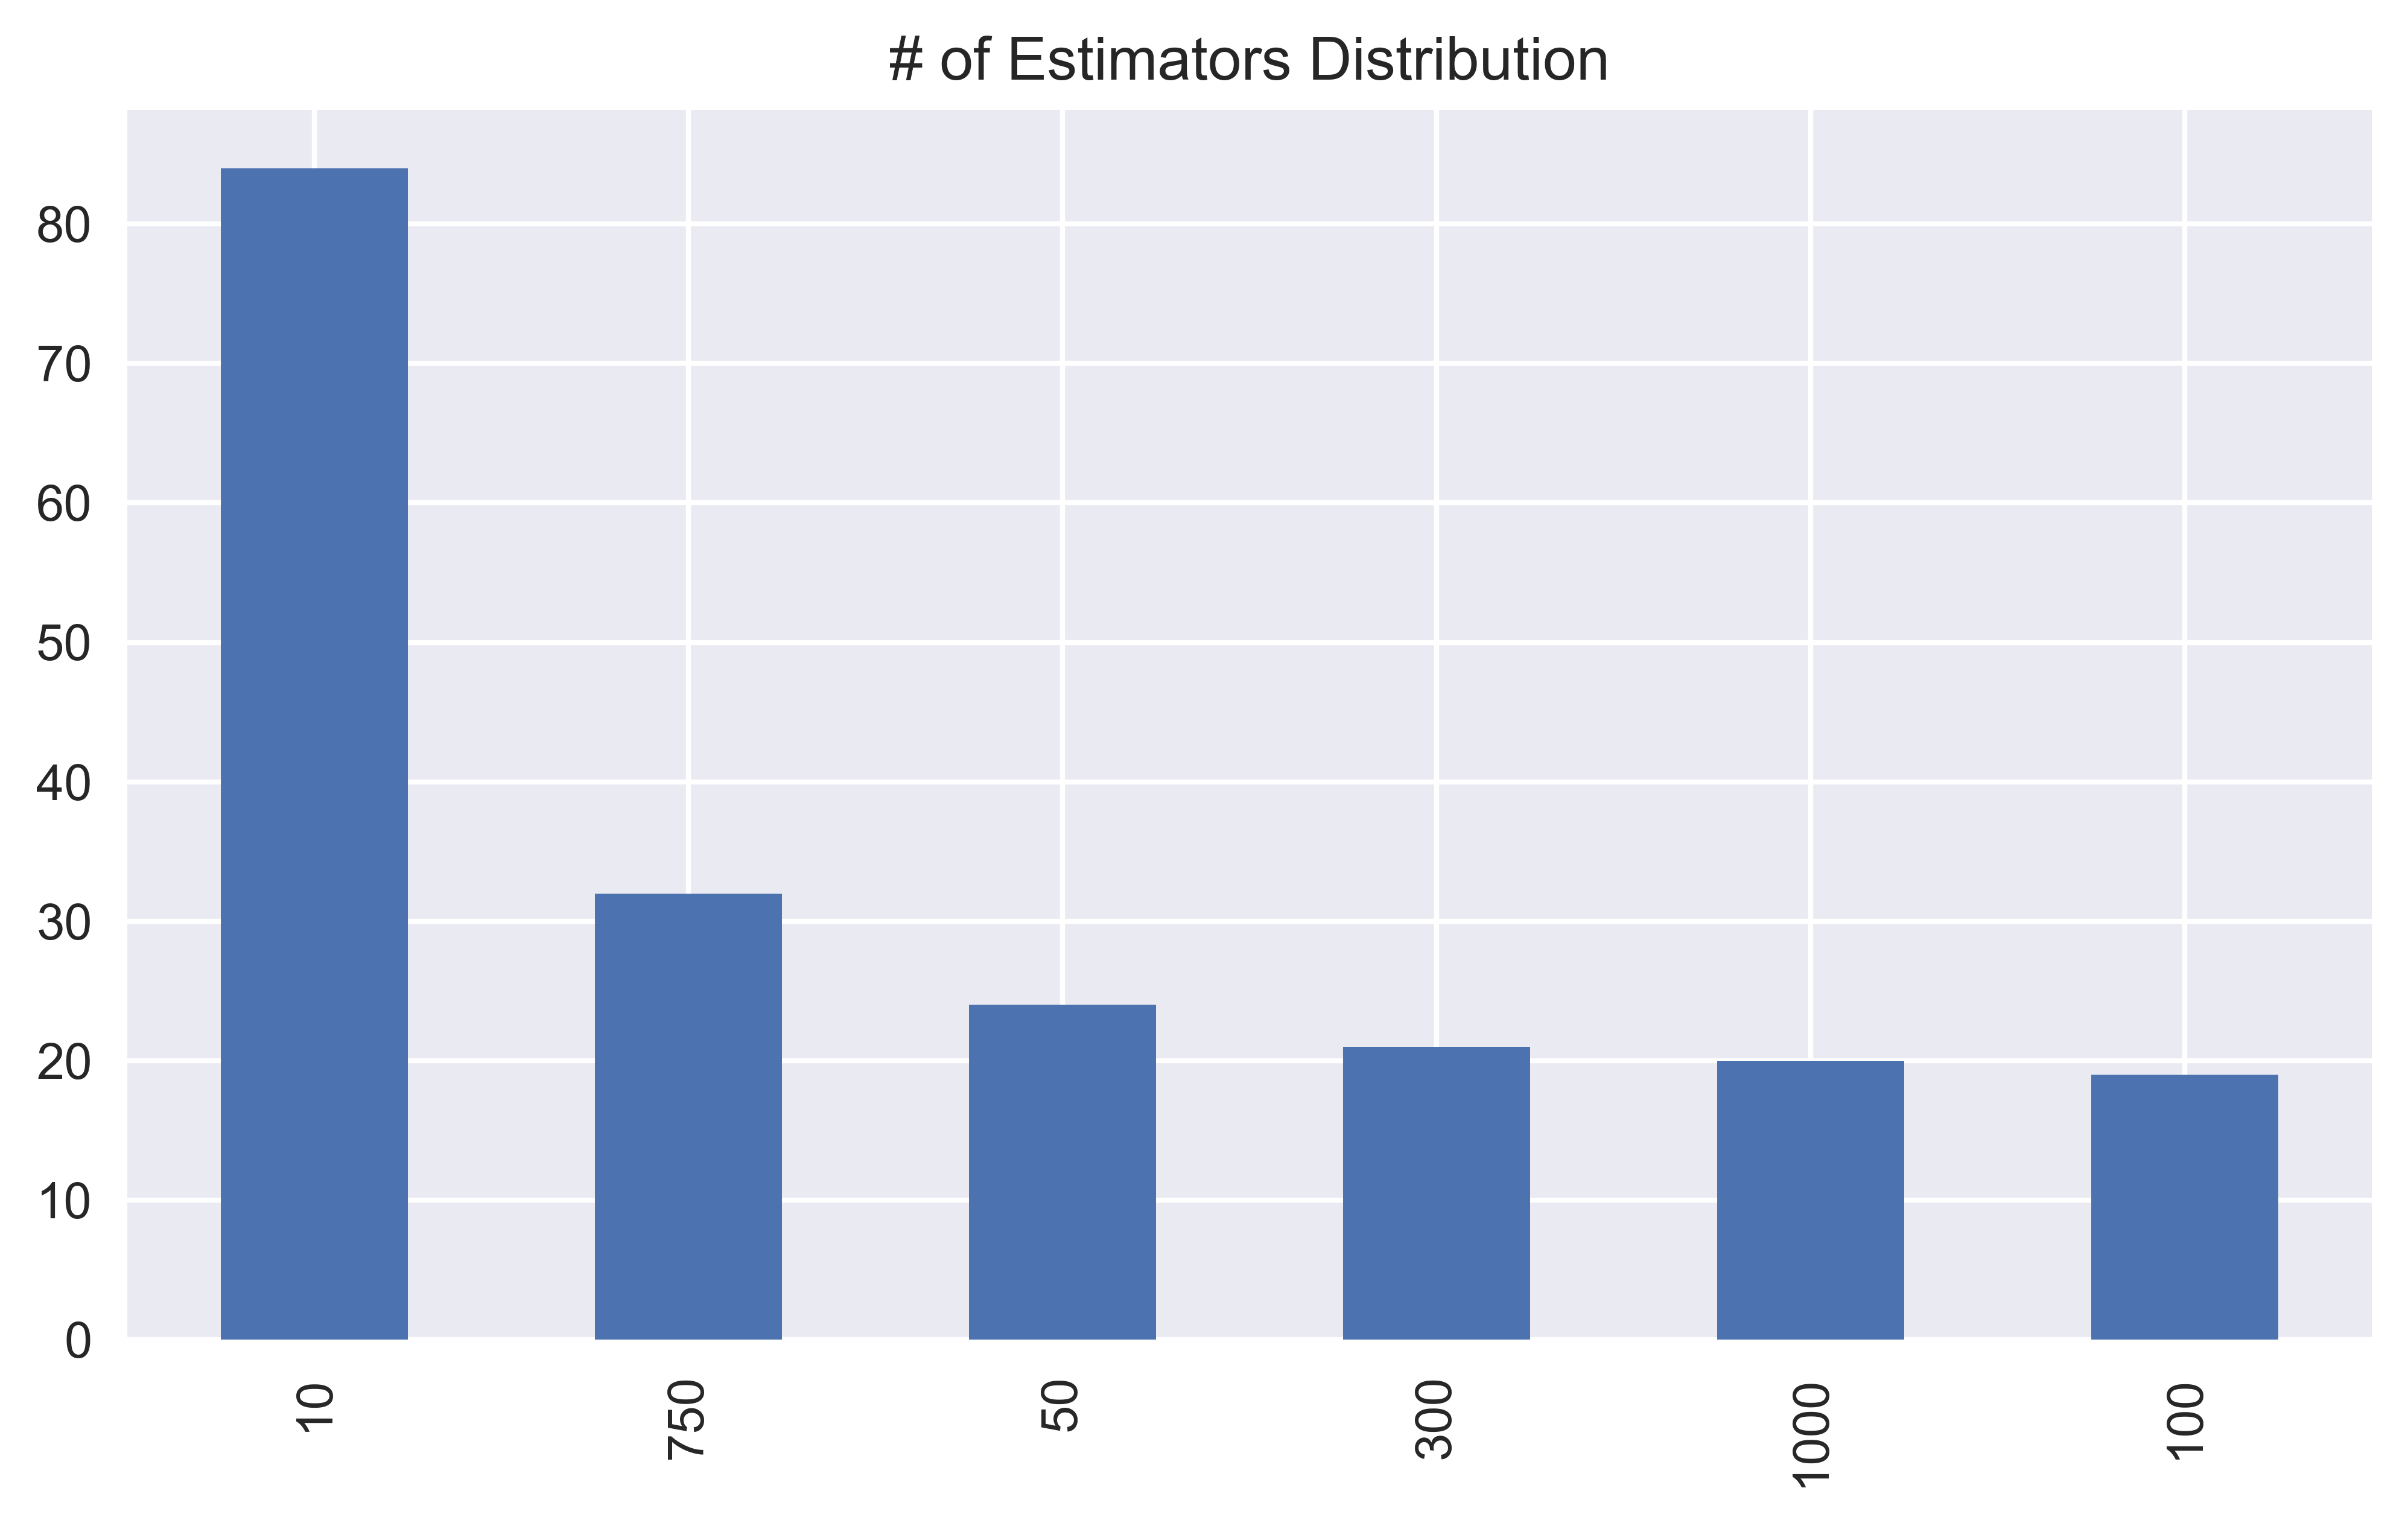

In [ ]:
results_df['n_estimators'].value_counts() \
                          .plot \
                          .bar(title=('# of Estimators' 
                                      ' Distribution'))

# plt.tight_layout()
# plt.savefig('images/ch9_im15.png', dpi=300)
# plt.show()

6. Plot the evolution of the observed losses over iterations:

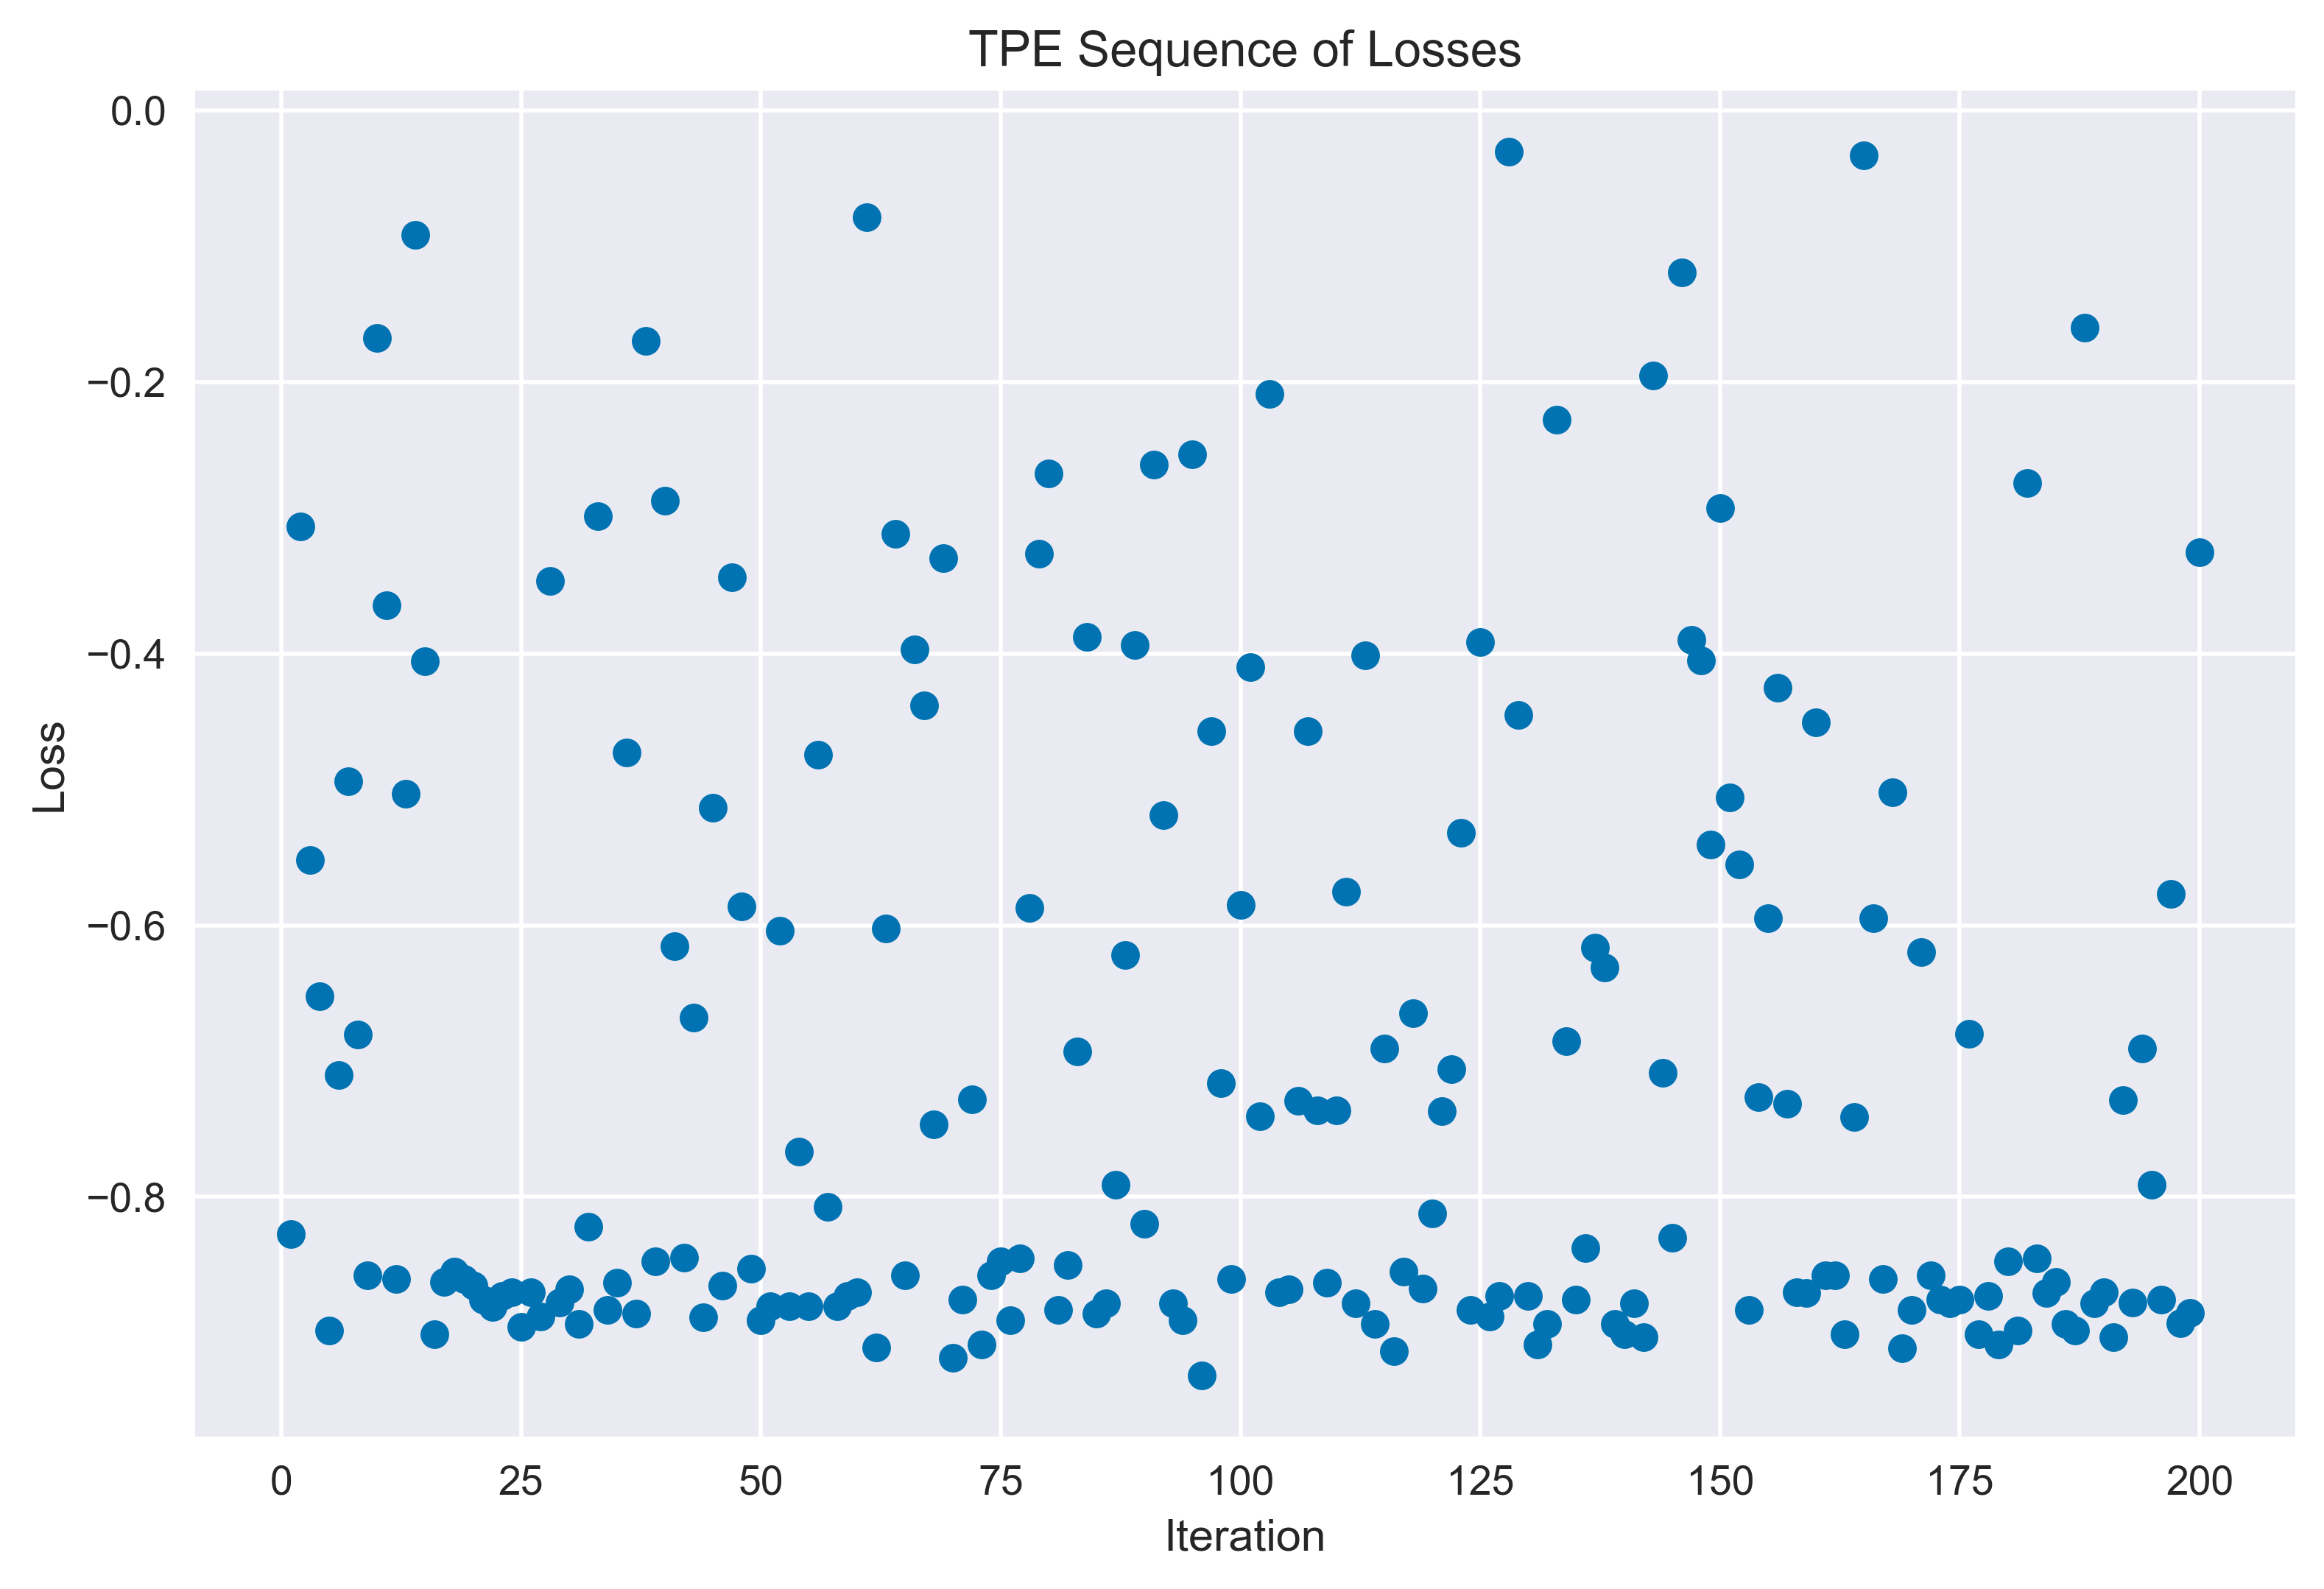

In [ ]:
fig, ax = plt.subplots()
ax.plot(results_df.iteration, results_df.loss, 'o')
ax.set(title='TPE Sequence of Losses', 
       xlabel='Iteration',
       ylabel='Loss')

plt.tight_layout()
plt.savefig('images/ch9_im16.png', dpi=300)
plt.show()